In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Charger le dataset une seule fois pour tout le notebook
df = pd.read_parquet('../data/STEP11_earthquakes.parquet')

### Boxplots magnitudes uniformisées

Text(0.5, 0, 'Magnitude uniformisée')

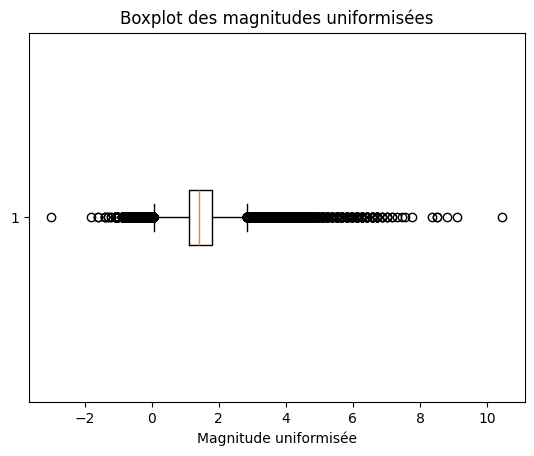

In [7]:
# Utiliser le dataset déjà chargé (df) pour les analyses suivantes
df_uniform = df.dropna(subset=['mag_uniforme'])  # Supprimer les NaN
stats = df_uniform['mag_uniforme'].describe()
q1 = stats['25%']
median = stats['50%']
q3 = stats['75%']
min_val = stats['min']
max_val = stats['max']
mean_val = stats['mean']

# Créer le boxplot pour mag_uniforme (horizontal)
fig2, ax2 = plt.subplots()
ax2.boxplot(df_uniform['mag_uniforme'], vert=False)
ax2.set_title('Boxplot des magnitudes uniformisées')
ax2.set_xlabel('Magnitude uniformisée')

### Type de magnitude

(array([0, 1, 2, 3]),
 [Text(0, 0, 'ml'), Text(1, 0, 'md'), Text(2, 0, 'mh'), Text(3, 0, 'Others')])

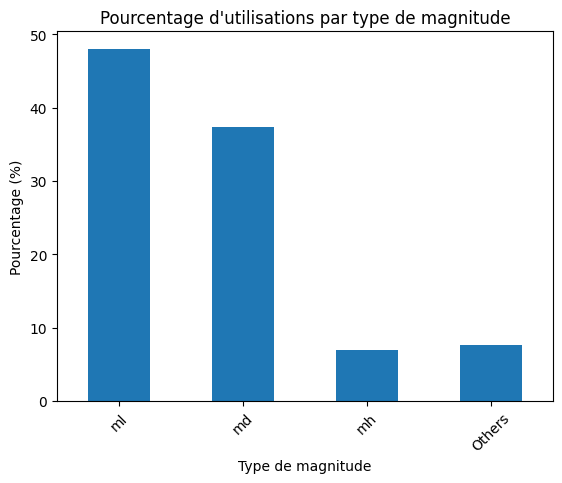

In [8]:
# Utiliser le dataset déjà chargé (df) pour les statistiques de type de magnitude
df_stats = df.dropna(subset=['type_magnitude'])  # Supprimer les NaN dans type_magnitude
magtype_counts = df_stats['type_magnitude'].value_counts(normalize=True) * 100
others = magtype_counts[magtype_counts < 3].sum()
magtype_counts = magtype_counts[magtype_counts >= 3]
if others > 0:
    magtype_counts['Others'] = others

fig, ax = plt.subplots()
magtype_counts.plot(kind='bar', ax=ax)
ax.set_title("Pourcentage d'utilisations par type de magnitude")
ax.set_xlabel('Type de magnitude')
ax.set_ylabel('Pourcentage (%)')
plt.xticks(rotation=45)

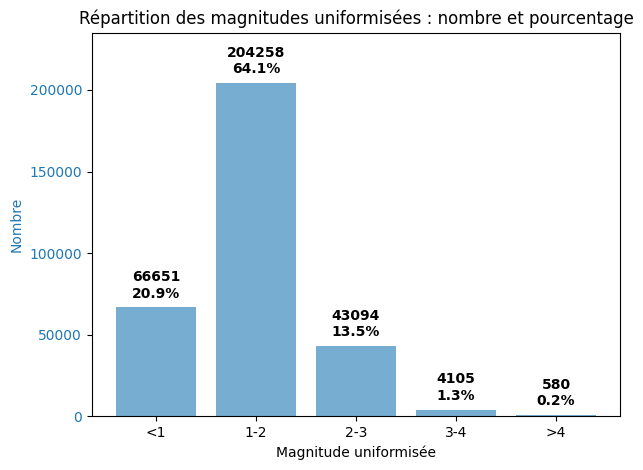

In [9]:
# Utiliser le dataset déjà chargé (df) pour la répartition des magnitudes uniformisées
df_uniform = df.dropna(subset=['mag_uniforme'])  # Supprimer les NaN
bins = [-float('inf'), 1, 2, 3, 4, float('inf')]
labels = ['<1', '1-2', '2-3', '3-4', '>4']
mag_uniforme_bins = pd.cut(df_uniform['mag_uniforme'], bins=bins, labels=labels)
proportions = mag_uniforme_bins.value_counts(normalize=True).sort_index() * 100
counts = mag_uniforme_bins.value_counts().sort_index()

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Magnitude uniformisée')
ax1.set_ylabel('Nombre', color=color)
bars = ax1.bar(labels, counts, color=color, alpha=0.6, label='Nombre')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 235000)  # Limite de l'axe y

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.annotate(f'{int(height)}\n{proportions.iloc[i]:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')

plt.title("Répartition des magnitudes uniformisées : nombre et pourcentage")
fig.tight_layout()
plt.show()

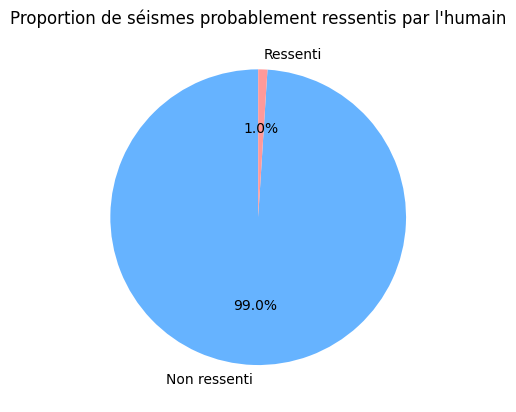

In [19]:
# Création d'un camembert pour la proportion de séismes ressentis ou non ressentis par l'humain
"""
Un séisme est considéré comme ressenti si :
- mag_uniforme > 4.0
- OU mag_uniforme > 3.0 et profondeur < 20 km
Sinon non ressenti, ou NaN si les deux valeurs sont nulles
"""
ressenti_counts = df['ressenti'].value_counts()
sizes = [ressenti_counts.get('non', 0), ressenti_counts.get('oui', 0)]
labels_pie = ['Non ressenti', 'Ressenti']

fig_pie, ax_pie = plt.subplots()
ax_pie.pie(sizes, labels=labels_pie, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
ax_pie.set_title("Proportion de séismes probablement ressentis par l'humain")
plt.show()

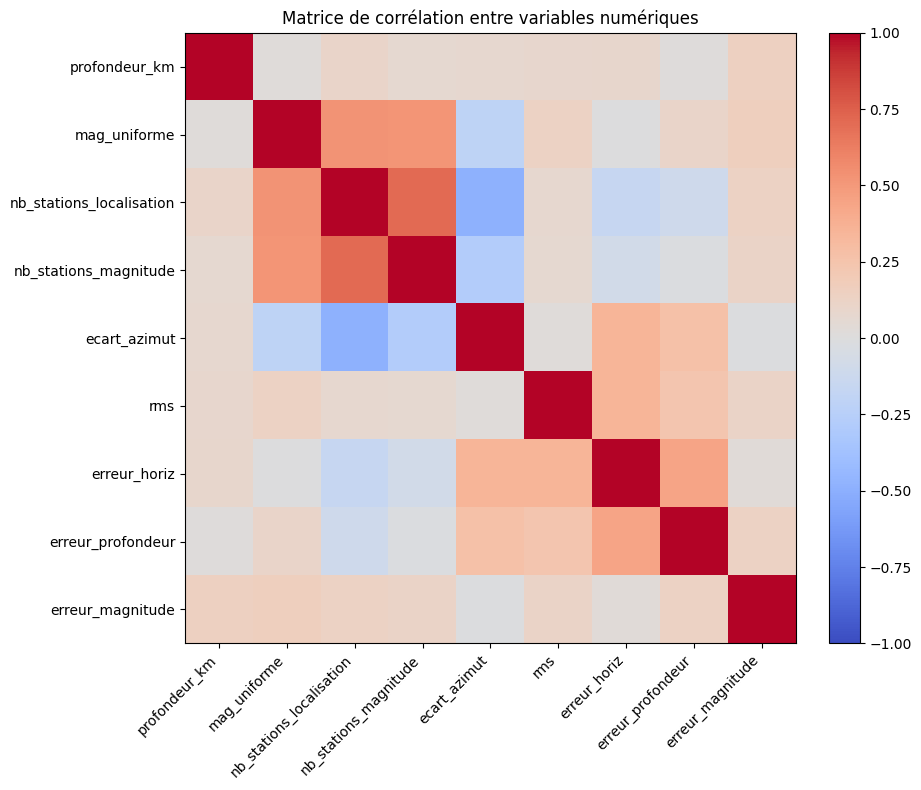

In [14]:
import itertools

# Sélection des colonnes numériques pertinentes (on exclut 'date_maj_infos' pour la corrélation)
cols_corr = [
    'profondeur_km', 'mag_uniforme', 'nb_stations_localisation',
    'nb_stations_magnitude', 'ecart_azimut', 'rms',
    'erreur_horiz', 'erreur_profondeur', 'erreur_magnitude'
]

# Définir df_plot en retirant les NaN dans toutes les colonnes concernées
# pour éviter les erreurs lors du calcul de la matrice de corrélation

df_plot = df.dropna(subset=cols_corr)

corr_matrix = df_plot[cols_corr].corr()

fig_corr_matrix, ax_corr = plt.subplots(figsize=(10, 8))
im = ax_corr.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
ax_corr.set_xticks(range(len(cols_corr)))
ax_corr.set_yticks(range(len(cols_corr)))
ax_corr.set_xticklabels(cols_corr, rotation=45, ha='right')
ax_corr.set_yticklabels(cols_corr)
plt.colorbar(im, ax=ax_corr, fraction=0.046, pad=0.04)
ax_corr.set_title("Matrice de corrélation entre variables numériques")

plt.tight_layout()
plt.show()


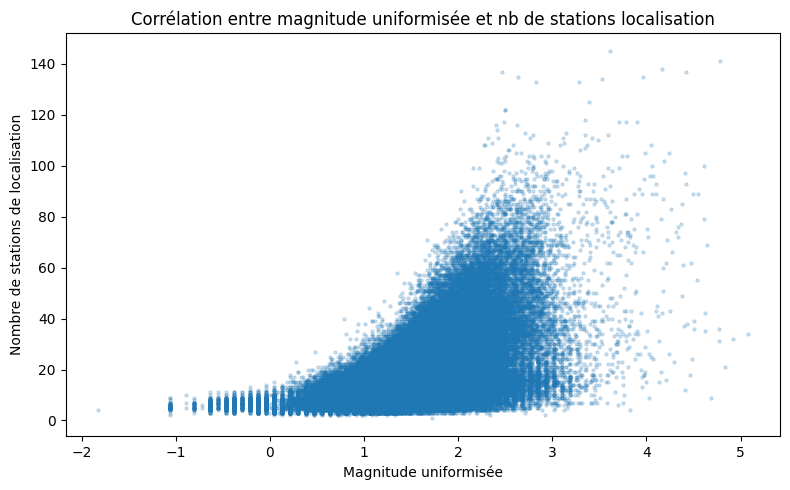

In [15]:
# Affichage du nuage de points et de la corrélation entre mag_uniforme et nb_stations_localisation
fig_corr_stations_mag, ax = plt.subplots(figsize=(8, 5))
ax.scatter(df_plot['mag_uniforme'], df_plot['nb_stations_localisation'], alpha=0.2, s=5)
ax.set_xlabel('Magnitude uniformisée')
ax.set_ylabel('Nombre de stations de localisation')
ax.set_title('Corrélation entre magnitude uniformisée et nb de stations localisation')
plt.tight_layout()
plt.show()

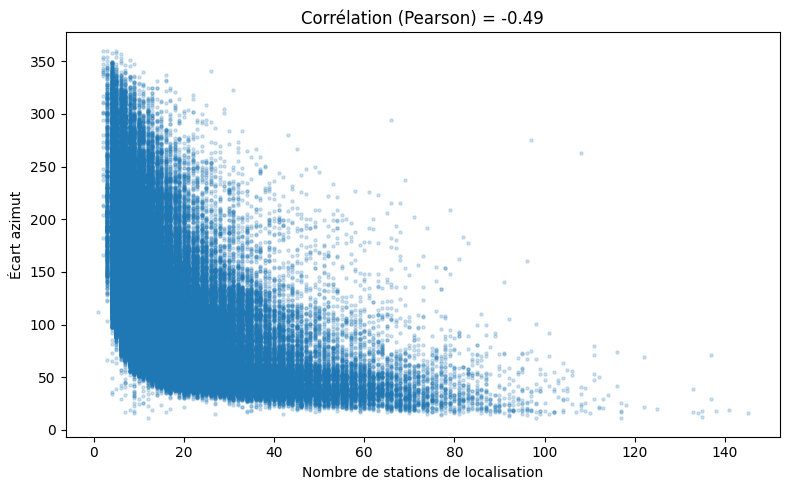

In [16]:
# Calcul de la corrélation de Pearson entre nb_stations_localisation et ecart_azimut
corr_value = df_plot['nb_stations_localisation'].corr(df_plot['ecart_azimut'])

# Affichage du nuage de points avec la valeur de corrélation
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(df_plot['nb_stations_localisation'], df_plot['ecart_azimut'], alpha=0.2, s=5)
ax.set_xlabel('Nombre de stations de localisation')
ax.set_ylabel('Écart azimut')
ax.set_title(f'Corrélation (Pearson) = {corr_value:.2f}')
plt.tight_layout()
plt.show()